# Deep Learning

## Deep Learning 을 위한 데이터 준비

Using PyTorch version: 1.9.0  Device: cpu
X_train: torch.Size([32, 1, 28, 28]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


/Users/adam/opt/anaconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


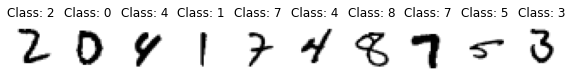

In [1]:
''' 1. Module Import '''
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

''' 2. 딥러닝 모델을 설계할 때 활용하는 장비 확인 '''
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
print('Using PyTorch version:', torch.__version__, ' Device:', DEVICE)

BATCH_SIZE = 32
EPOCHS = 10

''' 3. MNIST 데이터 다운로드 (Train set, Test set 분리하기) '''
train_dataset = datasets.MNIST(root = "../data/MNIST",
                               train = True,
                               download = True,
                               transform = transforms.ToTensor())

test_dataset = datasets.MNIST(root = "../data/MNIST",
                              train = False,
                              transform = transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = BATCH_SIZE,
                                           shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = False)

''' 4. 데이터 확인하기 '''
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break
    
pltsize = 1
plt.figure(figsize=(10 * pltsize, pltsize))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.axis('off')
    plt.imshow(X_train[i, :, :, :].numpy().reshape(28, 28), cmap = "gray_r")
    plt.title('Class: ' + str(y_train[i].item()))    

## Dropout

### 모델 설계

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)
        self.dropout_prob = 0.5

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.fc1(x)
        x = F.sigmoid(x)
        x = F.dropout(x, training = self.training, p = self.dropout_prob)
        x = self.fc2(x)
        x = F.sigmoid(x)
        x = F.dropout(x, training = self.training, p = self.dropout_prob)
        x = self.fc3(x)
        x = F.log_softmax(x, dim = 1)
        return x

In [3]:
''' Optimizer, Objective Function 설정하기 '''
model = Net().to(DEVICE)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum = 0.5)
criterion = nn.CrossEntropyLoss()

print(model)

''' MLP 모델 학습을 진행하며 학습 데이터에 대한 모델 성능을 확인하는 함수 정의 '''
def train(model, train_loader, optimizer, log_interval):
    model.train()
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}".format(
                epoch, batch_idx * len(image), 
                len(train_loader.dataset), 100. * batch_idx / len(train_loader), 
                loss.item()))
            
''' 학습되는 과정 속에서 검증 데이터에 대한 모델 성능을 확인하는 함수 정의 '''
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim = True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()
    
    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy  

''' MLP 학습 실행하며 Train, Test set의 Loss 및 Test set Accuracy 확인하기 '''
for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, test_loss, test_accuracy))

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)
Train Epoch: 1 [0/60000 (0%)]	Train Loss: 2.426050


/Users/adam/opt/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 1 [6400/60000 (11%)]	Train Loss: 2.328610
Train Epoch: 1 [12800/60000 (21%)]	Train Loss: 2.306461
Train Epoch: 1 [19200/60000 (32%)]	Train Loss: 2.274695
Train Epoch: 1 [25600/60000 (43%)]	Train Loss: 2.357585
Train Epoch: 1 [32000/60000 (53%)]	Train Loss: 2.328877
Train Epoch: 1 [38400/60000 (64%)]	Train Loss: 2.349853
Train Epoch: 1 [44800/60000 (75%)]	Train Loss: 2.273973
Train Epoch: 1 [51200/60000 (85%)]	Train Loss: 2.260295
Train Epoch: 1 [57600/60000 (96%)]	Train Loss: 2.345739

[EPOCH: 1], 	Test Loss: 0.0713, 	Test Accuracy: 12.18 % 

Train Epoch: 2 [0/60000 (0%)]	Train Loss: 2.265782
Train Epoch: 2 [6400/60000 (11%)]	Train Loss: 2.339506
Train Epoch: 2 [12800/60000 (21%)]	Train Loss: 2.262650
Train Epoch: 2 [19200/60000 (32%)]	Train Loss: 2.330726
Train Epoch: 2 [25600/60000 (43%)]	Train Loss: 2.297290
Train Epoch: 2 [32000/60000 (53%)]	Train Loss: 2.232897
Train Epoch: 2 [38400/60000 (64%)]	Train Loss: 2.290023
Train Epoch: 2 [44800/60000 (75%)]	Train Loss: 2.102

## Dropout + ReLU 적용

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)
        self.dropout_prob = 0.5

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.fc1(x)
        x = F.relu(x)
        x = F.dropout(x, training = self.training, p = self.dropout_prob)
        x = self.fc2(x)
        x = F.relu(x)
        x = F.dropout(x, training = self.training, p = self.dropout_prob)
        x = self.fc3(x)
        x = F.log_softmax(x, dim = 1)
        return x

In [5]:
''' Optimizer, Objective Function 설정하기 '''
model = Net().to(DEVICE)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum = 0.5)
criterion = nn.CrossEntropyLoss()

print(model)

''' MLP 모델 학습을 진행하며 학습 데이터에 대한 모델 성능을 확인하는 함수 정의 '''
def train(model, train_loader, optimizer, log_interval):
    model.train()
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}".format(
                epoch, batch_idx * len(image), 
                len(train_loader.dataset), 100. * batch_idx / len(train_loader), 
                loss.item()))
            
''' 학습되는 과정 속에서 검증 데이터에 대한 모델 성능을 확인하는 함수 정의 '''
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim = True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()
    
    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy  

''' MLP 학습 실행하며 Train, Test set의 Loss 및 Test set Accuracy 확인하기 '''
for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, test_loss, test_accuracy))

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)
Train Epoch: 1 [0/60000 (0%)]	Train Loss: 2.303803
Train Epoch: 1 [6400/60000 (11%)]	Train Loss: 2.044045
Train Epoch: 1 [12800/60000 (21%)]	Train Loss: 0.926277
Train Epoch: 1 [19200/60000 (32%)]	Train Loss: 1.173091
Train Epoch: 1 [25600/60000 (43%)]	Train Loss: 0.641563
Train Epoch: 1 [32000/60000 (53%)]	Train Loss: 0.836639
Train Epoch: 1 [38400/60000 (64%)]	Train Loss: 0.523656
Train Epoch: 1 [44800/60000 (75%)]	Train Loss: 0.401377
Train Epoch: 1 [51200/60000 (85%)]	Train Loss: 0.375473
Train Epoch: 1 [57600/60000 (96%)]	Train Loss: 0.533670

[EPOCH: 1], 	Test Loss: 0.0100, 	Test Accuracy: 91.04 % 

Train Epoch: 2 [0/60000 (0%)]	Train Loss: 0.456933
Train Epoch: 2 [6400/60000 (11%)]	Train Loss: 0.305147
Train Epoch: 2 [12800/60000 (21%)]	Train Loss: 0.313585
Train Epoch: 2 [19200/60000 (32%)

## Dropout + ReLU + Batch Normalization 적용

In [6]:
''' Multi Layer Perceptron (MLP) 모델 설계하기 '''
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)
        self.dropout_prob = 0.5
        self.batch_norm1 = nn.BatchNorm1d(512)
        self.batch_norm2 = nn.BatchNorm1d(256)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.fc1(x)
        x = self.batch_norm1(x)
        x = F.relu(x)
        x = F.dropout(x, training = self.training, p = self.dropout_prob)
        x = self.fc2(x)
        x = self.batch_norm2(x)
        x = F.relu(x)
        x = F.dropout(x, training = self.training, p = self.dropout_prob)
        x = self.fc3(x)
        x = F.log_softmax(x, dim = 1)
        return x

In [7]:
''' Optimizer, Objective Function 설정하기 '''
model = Net().to(DEVICE)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum = 0.5)
criterion = nn.CrossEntropyLoss()

print(model)

''' MLP 모델 학습을 진행하며 학습 데이터에 대한 모델 성능을 확인하는 함수 정의 '''
def train(model, train_loader, optimizer, log_interval):
    model.train()
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}".format(
                epoch, batch_idx * len(image), 
                len(train_loader.dataset), 100. * batch_idx / len(train_loader), 
                loss.item()))
            
''' 학습되는 과정 속에서 검증 데이터에 대한 모델 성능을 확인하는 함수 정의 '''
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim = True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()
    
    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy  

''' MLP 학습 실행하며 Train, Test set의 Loss 및 Test set Accuracy 확인하기 '''
for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, test_loss, test_accuracy))

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
  (batch_norm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
Train Epoch: 1 [0/60000 (0%)]	Train Loss: 2.431203
Train Epoch: 1 [6400/60000 (11%)]	Train Loss: 0.400178
Train Epoch: 1 [12800/60000 (21%)]	Train Loss: 0.205539
Train Epoch: 1 [19200/60000 (32%)]	Train Loss: 0.147435
Train Epoch: 1 [25600/60000 (43%)]	Train Loss: 0.314690
Train Epoch: 1 [32000/60000 (53%)]	Train Loss: 0.614389
Train Epoch: 1 [38400/60000 (64%)]	Train Loss: 0.159236
Train Epoch: 1 [44800/60000 (75%)]	Train Loss: 0.231939
Train Epoch: 1 [51200/60000 (85%)]	Train Loss: 0.201809
Train Epoch: 1 [57600/60000 (96%)]	Train Loss: 0.385036

[EPOCH: 1], 	Test Loss: 0.0049, 	Test Accuracy: 95.31 % 


## 사람의 손글씨 데이터인 MNIST를 이용해 Multi Layer Perceptron 설계할 때 Dropout + ReLU + Batch Normalization + He Uniform Initialization 적용

In [8]:
''' Optimizer, Objective Function 설정하기 '''
import torch.nn.init as init
def weight_init(m):
    if isinstance(m, nn.Linear):
        init.kaiming_uniform_(m.weight.data)

model = Net().to(DEVICE)
model.apply(weight_init)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum = 0.5)
criterion = nn.CrossEntropyLoss()

print(model)

''' MLP 학습 실행하며 Train, Test set의 Loss 및 Test set Accuracy 확인하기 '''
for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, test_loss, test_accuracy))

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
  (batch_norm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
Train Epoch: 1 [0/60000 (0%)]	Train Loss: 3.195416
Train Epoch: 1 [6400/60000 (11%)]	Train Loss: 0.591121
Train Epoch: 1 [12800/60000 (21%)]	Train Loss: 0.579755
Train Epoch: 1 [19200/60000 (32%)]	Train Loss: 0.858828
Train Epoch: 1 [25600/60000 (43%)]	Train Loss: 0.551197
Train Epoch: 1 [32000/60000 (53%)]	Train Loss: 0.670591
Train Epoch: 1 [38400/60000 (64%)]	Train Loss: 0.512658
Train Epoch: 1 [44800/60000 (75%)]	Train Loss: 0.650460
Train Epoch: 1 [51200/60000 (85%)]	Train Loss: 0.472974
Train Epoch: 1 [57600/60000 (96%)]	Train Loss: 0.317582

[EPOCH: 1], 	Test Loss: 0.0068, 	Test Accuracy: 93.52 % 


In [9]:
import torch.nn.init as init
def weight_init(m):
    if isinstance(m, nn.Linear):
        init.kaiming_uniform_(m.weight.data)

model = Net().to(DEVICE)
model.apply(weight_init)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
criterion = nn.CrossEntropyLoss()

print(model)

for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, test_loss, test_accuracy))

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
  (batch_norm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
Train Epoch: 1 [0/60000 (0%)]	Train Loss: 3.091649
Train Epoch: 1 [6400/60000 (11%)]	Train Loss: 0.169459
Train Epoch: 1 [12800/60000 (21%)]	Train Loss: 0.342087
Train Epoch: 1 [19200/60000 (32%)]	Train Loss: 0.588417
Train Epoch: 1 [25600/60000 (43%)]	Train Loss: 0.599481
Train Epoch: 1 [32000/60000 (53%)]	Train Loss: 0.383133
Train Epoch: 1 [38400/60000 (64%)]	Train Loss: 0.187853
Train Epoch: 1 [44800/60000 (75%)]	Train Loss: 0.475380
Train Epoch: 1 [51200/60000 (85%)]	Train Loss: 0.330638
Train Epoch: 1 [57600/60000 (96%)]	Train Loss: 0.260193

[EPOCH: 1], 	Test Loss: 0.0041, 	Test Accuracy: 95.97 % 


### 예측

예측 결과 : 7
(1, 28, 28)


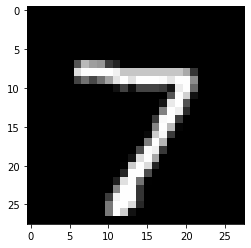

In [69]:
batch_iterator = iter(test_loader)
images = next(batch_iterator)

model.eval()  # 신경망을 추론 모드로 전환

output = model(images[0])  # 데이터를 입력하고 출력을 계산
result = output.detach().numpy()
print("예측 결과 : {}".format(np.argmax(result[0])))

image = images[0].detach().numpy()
plt.imshow(image[0].reshape(28, 28), cmap='gray')

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml

import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

mnist = fetch_openml('mnist_784', version=1, cache=True)

mnist.target = mnist.target.astype(np.int8)

예측 결과 : 9
이 이미지 데이터의 정답 레이블은 9입니다


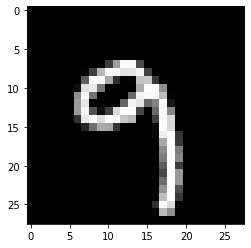

In [33]:
X = mnist.data/255  # 0-255값을 [0,1] 구간으로 정규화
y = mnist.target

X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=1/7, random_state=0)

X_train = torch.Tensor(X_train)
X_test = torch.Tensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

ds_train = TensorDataset(X_train, y_train)
ds_test = TensorDataset(X_test, y_test)

loader_train = DataLoader(ds_train, batch_size=64, shuffle=True)
loader_test = DataLoader(ds_test, batch_size=64, shuffle=False)

index = 42

model.eval()  # 신경망을 추론 모드로 전환
data = X_test[index]

output = model(data)  # 데이터를 입력하고 출력을 계산
predicted = output[0].detach().numpy()
print("예측 결과 : {}".format(np.argmax(predicted)))

X_test_show = (X_test[index]).numpy()
plt.imshow(X_test_show.reshape(28, 28), cmap='gray')
print("이 이미지 데이터의 정답 레이블은 {:.0f}입니다".format(y_test[index]))

## 선형 회귀

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

### 단순 선형 회귀

In [2]:
# 데이터
x_train = torch.FloatTensor([[1], [2], [3]])
y_train = torch.FloatTensor([[2], [4], [6]])

# 단순 선형 회귀 모델 생성 
# input_dim=1, output_dim=1.
model = nn.Linear(1,1)

# 모델의 하이퍼파라미터 출력
print(list(model.parameters()))

#최적화 함수 선택
optimizer = torch.optim.SGD(model.parameters(), lr=0.01) 

# 전체 훈련 데이터에 대해 경사 하강법을 2,000회 반복
nb_epochs = 2000
for epoch in range(nb_epochs+1):

    # H(x) 계산
    prediction = model(x_train)

    # cost 계산
    cost = F.mse_loss(prediction, y_train) # <== 파이토치에서 제공하는 평균 제곱 오차 함수

    # cost로 H(x) 개선하는 부분
    # gradient를 0으로 초기화
    optimizer.zero_grad()
    # 비용 함수를 미분하여 gradient 계산
    cost.backward() # backward 연산
    # W와 b를 업데이트
    optimizer.step()

    if epoch % 100 == 0:
    # 100번마다 로그 출력
      print('Epoch {:4d}/{} Cost: {:.6f}'.format(
          epoch, nb_epochs, cost.item()
      ))

[Parameter containing:
tensor([[0.7695]], requires_grad=True), Parameter containing:
tensor([-0.5948], requires_grad=True)]
Epoch    0/2000 Cost: 10.347617
Epoch  100/2000 Cost: 0.000178
Epoch  200/2000 Cost: 0.000110
Epoch  300/2000 Cost: 0.000068
Epoch  400/2000 Cost: 0.000042
Epoch  500/2000 Cost: 0.000026
Epoch  600/2000 Cost: 0.000016
Epoch  700/2000 Cost: 0.000010
Epoch  800/2000 Cost: 0.000006
Epoch  900/2000 Cost: 0.000004
Epoch 1000/2000 Cost: 0.000002
Epoch 1100/2000 Cost: 0.000001
Epoch 1200/2000 Cost: 0.000001
Epoch 1300/2000 Cost: 0.000001
Epoch 1400/2000 Cost: 0.000000
Epoch 1500/2000 Cost: 0.000000
Epoch 1600/2000 Cost: 0.000000
Epoch 1700/2000 Cost: 0.000000
Epoch 1800/2000 Cost: 0.000000
Epoch 1900/2000 Cost: 0.000000
Epoch 2000/2000 Cost: 0.000000


In [3]:
# 임의의 입력 4를 선언
new_var =  torch.FloatTensor([[4.0]]) 
# 입력한 값 4에 대해서 예측값 y를 리턴받아서 pred_y에 저장
pred_y = model(new_var) # forward 연산
# y = 2x 이므로 입력이 4라면 y가 8에 가까운 값이 나와야 제대로 학습이 된 것
print("훈련 후 입력이 4일 때의 예측값 :", pred_y) 

훈련 후 입력이 4일 때의 예측값 : tensor([[8.0003]], grad_fn=<AddmmBackward>)


In [4]:
print(list(model.parameters()))

[Parameter containing:
tensor([[2.0002]], requires_grad=True), Parameter containing:
tensor([-0.0004], requires_grad=True)]


### 단순 선형 회귀 - 클래스로 구현

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

torch.manual_seed(42)

# 데이터
x_train = torch.FloatTensor([[1], [2], [3]])
y_train = torch.FloatTensor([[2], [4], [6]])

In [6]:
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(1, 1)

    def forward(self, x):
        return self.linear(x)

In [7]:
model = LinearRegressionModel()

In [8]:
# optimizer 설정. 경사 하강법 SGD를 사용하고 learning rate를 의미하는 lr은 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=0.01) 

In [9]:
# 전체 훈련 데이터에 대해 경사 하강법을 2,000회 반복
nb_epochs = 2000
for epoch in range(nb_epochs+1):

    # H(x) 계산
    prediction = model(x_train)

    # cost 계산
    cost = F.mse_loss(prediction, y_train) # <== 파이토치에서 제공하는 평균 제곱 오차 함수

    # cost로 H(x) 개선하는 부분
    # gradient를 0으로 초기화
    optimizer.zero_grad()
    # 비용 함수를 미분하여 gradient 계산
    cost.backward() # backward 연산
    # W와 b를 업데이트
    optimizer.step()

    if epoch % 100 == 0:
    # 100번마다 로그 출력
      print('Epoch {:4d}/{} Cost: {:.6f}'.format(
          epoch, nb_epochs, cost.item()
      ))

Epoch    0/2000 Cost: 3.710179
Epoch  100/2000 Cost: 0.117398
Epoch  200/2000 Cost: 0.072545
Epoch  300/2000 Cost: 0.044828
Epoch  400/2000 Cost: 0.027701
Epoch  500/2000 Cost: 0.017118
Epoch  600/2000 Cost: 0.010578
Epoch  700/2000 Cost: 0.006536
Epoch  800/2000 Cost: 0.004039
Epoch  900/2000 Cost: 0.002496
Epoch 1000/2000 Cost: 0.001542
Epoch 1100/2000 Cost: 0.000953
Epoch 1200/2000 Cost: 0.000589
Epoch 1300/2000 Cost: 0.000364
Epoch 1400/2000 Cost: 0.000225
Epoch 1500/2000 Cost: 0.000139
Epoch 1600/2000 Cost: 0.000086
Epoch 1700/2000 Cost: 0.000053
Epoch 1800/2000 Cost: 0.000033
Epoch 1900/2000 Cost: 0.000020
Epoch 2000/2000 Cost: 0.000013


In [10]:
# 임의의 입력 4를 선언
new_var =  torch.FloatTensor([[4.0]]) 
# 입력한 값 4에 대해서 예측값 y를 리턴받아서 pred_y에 저장
pred_y = model(new_var) # forward 연산
# y = 2x 이므로 입력이 4라면 y가 8에 가까운 값이 나와야 제대로 학습이 된 것
print("훈련 후 입력이 4일 때의 예측값 :", pred_y) 

훈련 후 입력이 4일 때의 예측값 : tensor([[7.9929]], grad_fn=<AddmmBackward>)


In [11]:
print(list(model.parameters()))

[Parameter containing:
tensor([[1.9959]], requires_grad=True), Parameter containing:
tensor([0.0093], requires_grad=True)]


### 다중 선형 회귀 모델

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

torch.manual_seed(42)

# 데이터
x_train = torch.FloatTensor([[73, 80, 75],
                             [93, 88, 93],
                             [89, 91, 90],
                             [96, 98, 100],
                             [73, 66, 70]])
y_train = torch.FloatTensor([[152], [185], [180], [196], [142]])

In [13]:
class MultivariateLinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(3, 1) # 다중 선형 회귀이므로 input_dim=3, output_dim=1.

    def forward(self, x):
        return self.linear(x)

In [14]:
model = MultivariateLinearRegressionModel()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-5) 

In [15]:
nb_epochs = 2000
for epoch in range(nb_epochs+1):

    # H(x) 계산
    prediction = model(x_train)
    # model(x_train)은 model.forward(x_train)와 동일함.

    # cost 계산
    cost = F.mse_loss(prediction, y_train) # <== 파이토치에서 제공하는 평균 제곱 오차 함수

    # cost로 H(x) 개선하는 부분
    # gradient를 0으로 초기화
    optimizer.zero_grad()
    # 비용 함수를 미분하여 gradient 계산
    cost.backward()
    # W와 b를 업데이트
    optimizer.step()

    if epoch % 100 == 0:
    # 100번마다 로그 출력
      print('Epoch {:4d}/{} Cost: {:.6f}'.format(
          epoch, nb_epochs, cost.item()
      ))

Epoch    0/2000 Cost: 10995.318359
Epoch  100/2000 Cost: 2.533191
Epoch  200/2000 Cost: 2.409125
Epoch  300/2000 Cost: 2.291532
Epoch  400/2000 Cost: 2.180158
Epoch  500/2000 Cost: 2.074660
Epoch  600/2000 Cost: 1.974722
Epoch  700/2000 Cost: 1.880020
Epoch  800/2000 Cost: 1.790340
Epoch  900/2000 Cost: 1.705363
Epoch 1000/2000 Cost: 1.624877
Epoch 1100/2000 Cost: 1.548606
Epoch 1200/2000 Cost: 1.476381
Epoch 1300/2000 Cost: 1.407951
Epoch 1400/2000 Cost: 1.343122
Epoch 1500/2000 Cost: 1.281718
Epoch 1600/2000 Cost: 1.223515
Epoch 1700/2000 Cost: 1.168411
Epoch 1800/2000 Cost: 1.116184
Epoch 1900/2000 Cost: 1.066732
Epoch 2000/2000 Cost: 1.019865


In [18]:
# 임의의 입력
new_var =  torch.FloatTensor([[73, 80, 74]]) 
pred_y = model(new_var) # forward 연산
print("훈련 후 입력이 [73, 80, 74]일 때의 예측값 :", pred_y) 

훈련 후 입력이 [73, 80, 74]일 때의 예측값 : tensor([[152.7107]], grad_fn=<AddmmBackward>)


In [19]:
print(list(model.parameters()))

[Parameter containing:
tensor([[0.9541, 0.7449, 0.3099]], requires_grad=True), Parameter containing:
tensor([0.5357], requires_grad=True)]


### CSV 파일을 읽어서 선형 회귀 분석

In [20]:
import pandas as pd

import torch
from torch import nn

import matplotlib.pyplot as plt

In [24]:
data = pd.read_csv('./data/score.csv')
print(data.head())

X = torch.from_numpy(data[['iq', 'academy', 'game', 'tv']].values).unsqueeze(dim=1).float()
y = torch.from_numpy(data['score'].values).unsqueeze(dim=1).float()

print(X)
print(y)

  name  score   iq  academy  game  tv
0    A     90  140        2     1   0
1    B     75  125        1     3   3
2    C     77  120        1     0   4
3    D     83  135        2     3   2
4    E     65  105        0     4   4
tensor([[[140.,   2.,   1.,   0.]],

        [[125.,   1.,   3.,   3.]],

        [[120.,   1.,   0.,   4.]],

        [[135.,   2.,   3.,   2.]],

        [[105.,   0.,   4.,   4.]],

        [[123.,   3.,   1.,   1.]],

        [[132.,   3.,   4.,   1.]],

        [[115.,   1.,   1.,   3.]],

        [[128.,   4.,   0.,   0.]],

        [[131.,   2.,   2.,   3.]]])
tensor([[90.],
        [75.],
        [77.],
        [83.],
        [65.],
        [80.],
        [83.],
        [70.],
        [87.],
        [79.]])


"\nplt.xlim(0, 11);    plt.ylim(0, 8)\nplt.title('02_Linear_Regression_Model_Data')\nplt.scatter(x, y)\n\nplt.show()\n"

In [25]:
class MultivariateLinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(4, 1) # 다중 선형 회귀이므로 input_dim=4, output_dim=1.

    def forward(self, x):
        return self.linear(x)

In [26]:
model = MultivariateLinearRegressionModel()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-5) 

In [27]:
nb_epochs = 2000
for epoch in range(nb_epochs+1):

    # H(x) 계산
    prediction = model(X)

    # cost 계산
    cost = F.mse_loss(prediction, y) # <== 파이토치에서 제공하는 평균 제곱 오차 함수

    # cost로 H(x) 개선하는 부분
    # gradient를 0으로 초기화
    optimizer.zero_grad()
    # 비용 함수를 미분하여 gradient 계산
    cost.backward()
    # W와 b를 업데이트
    optimizer.step()

    if epoch % 100 == 0:
    # 100번마다 로그 출력
      print('Epoch {:4d}/{} Cost: {:.6f}'.format(
          epoch, nb_epochs, cost.item()
      ))

/var/folders/42/fxl3_n31121f16yj69fbrb_m0000gn/T/ipykernel_18337/661213645.py:8: UserWarning: Using a target size (torch.Size([10, 1])) that is different to the input size (torch.Size([10, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  cost = F.mse_loss(prediction, y) # <== 파이토치에서 제공하는 평균 제곱 오차 함수


Epoch    0/2000 Cost: 8489.842773
Epoch  100/2000 Cost: 85.621292
Epoch  200/2000 Cost: 85.400291
Epoch  300/2000 Cost: 85.182419
Epoch  400/2000 Cost: 84.967674
Epoch  500/2000 Cost: 84.756035
Epoch  600/2000 Cost: 84.547386
Epoch  700/2000 Cost: 84.341721
Epoch  800/2000 Cost: 84.139023
Epoch  900/2000 Cost: 83.939186
Epoch 1000/2000 Cost: 83.742218
Epoch 1100/2000 Cost: 83.548065
Epoch 1200/2000 Cost: 83.356712
Epoch 1300/2000 Cost: 83.168037
Epoch 1400/2000 Cost: 82.982071
Epoch 1500/2000 Cost: 82.798737
Epoch 1600/2000 Cost: 82.618057
Epoch 1700/2000 Cost: 82.439934
Epoch 1800/2000 Cost: 82.264305
Epoch 1900/2000 Cost: 82.091232
Epoch 2000/2000 Cost: 81.920586


In [28]:
# 임의의 입력
new_var =  torch.FloatTensor([[140, 2, 1, 1]]) 
pred_y = model(new_var) # forward 연산
print("훈련 후 입력이 [140, 2, 1, 1]일 때의 예측값 :", pred_y) 

훈련 후 입력이 [140, 2, 1, 1]일 때의 예측값 : tensor([[86.9952]], grad_fn=<AddmmBackward>)


In [29]:
print(list(model.parameters()))

[Parameter containing:
tensor([[ 0.6153, -0.0013, -0.1548,  0.5486]], requires_grad=True), Parameter containing:
tensor([0.4640], requires_grad=True)]
